In [27]:
import pandas as pd
import requests
import datetime
import numpy as np
from datetime import datetime
import time
from time import sleep
import json
import random

In [2]:
base_url = 'https://api.pushshift.io/reddit/search/submission/'
parameters = {'subreddit': 'completeanarchy', 'title' : 'ACAB'}

In [3]:
r = requests.get(base_url, params = parameters)

In [4]:
reddit_df = pd.DataFrame(r.json()['data'])

In [5]:
def getPushshiftData(query, after, before, sub, endpoint = 'submission', size = 25):
    url = 'https://api.pushshift.io/reddit/search/' + endpoint
    parameters = {'subreddit': sub, 'title' : query, 'after' : str(after), 'before' : str(before), 'size': 500}
    r = requests.get(url, parameters)
    try:
        data = r.json()
    except:
        data = {'data':[]}
        
    return data['data']

In [6]:
def collectSubData(subm, subStats):
    #subData = list() #list to store data points
    
    pd.DataFrame
    title = subm['title']
    url = subm['url']
    
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
        
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc'])
    numComms = subm['num_comments']
    permalink = subm['permalink']
    text = subm['selftext']
    
    subData.append((sub_id,title,url,author,score,created,numComms,permalink,flair))
    subStats[sub_id] = subData

In [7]:
def extractStats(data):
    
    subStats = {}
    subCount = 0
    
    while len(data) > 0:
        print(len(data))
        for submission in data:
            collectSubData(submission, subStats)
            subCount+=1
            
        # Calls getPushshiftData() with the created date of the last submission
        print(len(data))
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
        after = data[-1]['created_utc']
        data = getPushshiftData(query, after, before, sub)

    print(len(data))
    return(subStats)

Code snippets from https://rareloot.medium.com/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [8]:
def dt2unix(before, after, format = "%Y/%m/%d"):
    # input: two strings in the form yyyy/mm/dd
    # returns: tuple (before, after) as unix times
    beforeUnix = time.mktime(datetime.strptime(before, format).timetuple())
    afterUnix = time.mktime(datetime.strptime(after, format).timetuple())
    
    return(int(beforeUnix), int(afterUnix))

In [10]:
query = 'ACAB'
before = 1538352000 # "1538352000" #October 1st
after = 1514764800  #January 1st 
before, after = dt2unix("2020/1/1","2017/10/1")
sub = 'news'
data = getPushshiftData(query, after, before, sub) # Will run until all posts have been gathered 
dataDF = pd.DataFrame(data)

In [11]:
dataDF.keys()

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link',
       'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'updated_utc', 'url', 'whitelist_status', 'wls'],
      dtype='object'

In [12]:
dataDF['full_link']

0    https://www.reddit.com/r/news/comments/cnw6h5/...
Name: full_link, dtype: object

In [51]:
def extractData(data):
    dataDF = pd.DataFrame(data)
    toExtract = ['author',
                 'subreddit',
                  'created_utc',
                  'full_link', 
                  'id', 'is_self', 
                  'is_video', 
                  'locked', 
                  'num_comments', 
                  'num_crossposts', 
                  'pinned', 
                  'score',
                 'selftext',
                  'title']
    outDF = pd.DataFrame([])
    for query in toExtract:
        try:
            outDF[query] = dataDF[query]
        except:
            pass
        
    return(outDF)

In [52]:
extractData(data)

,author,subreddit,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,title
0,corburruto,news,1565318691,https://www.reddit.com/r/news/comments/cnw6h5/...,cnw6h5,False,False,False,0,0,False,1,,"Interesting read, Reddit will hate it because ..."


In [53]:
list_of_subs = ['completeanarchy']

In [54]:
def getNews(query, after, before, sublist = ['news','worldnews','gunpolitics']):
    combinedDF = pd.DataFrame()
    for sub in sublist:
        datai = getPushshiftData(query, after, before, sub)
        while(len(datai) > 0):
            print(len(datai))
            dataj = extractData(datai)
            combinedDF = combinedDF.append(dataj)
            after = datai[-1]['created_utc']
            print(before)
            datai = getPushshiftData(query, after, before, sub)
            #sleep(random.random())
            
    return(combinedDF)

In [55]:
after, before = dt2unix('2014/05/1', '2019/10/01')
stories = getNews('heat wave', after, before)

100
1569880800
100
1569880800


/usr/lib/python3/dist-packages/pandas/core/frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


14
1569880800


In [56]:
stories

,author,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,subreddit,title
0,TheKolbrin,1401036144,https://www.reddit.com/r/news/comments/26gd91/...,26gd91,False,NaN,NaN,0,NaN,NaN,1,,news,Heat wave hits Hanoi with record temperatures-...
1,eemma063,1404228548,https://www.reddit.com/r/news/comments/29kht5/...,29kht5,False,NaN,NaN,0,NaN,NaN,1,,news,Did you know-With the holiday and heat wave ap...
2,liltceo,1405660024,https://www.reddit.com/r/news/comments/2b0tt6/...,2b0tt6,False,NaN,NaN,3,NaN,NaN,5,,news,BBC News: UK temperature hits 2014 high as hea...
3,varun_n,1406626885,https://www.reddit.com/r/news/comments/2c12z2/...,2c12z2,False,NaN,NaN,1,NaN,NaN,1,,news,At least 15 people died as a heat wave sweeps ...
4,vitruv,1410919759,https://www.reddit.com/r/news/comments/2gmdrj/...,2gmdrj,False,NaN,NaN,5,NaN,NaN,16,,news,"Power grid groans, blackouts roll through L.A...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,The_Possessor,1565691679,https://www.reddit.com/r/news/comments/cpr6d9/...,cpr6d9,False,False,False,19,0.0,False,23,,news,Texas power demand sets record high as heat wa...
10,riqelme,1565726524,https://www.reddit.com/r/news/comments/cpyj75/...,cpyj75,False,False,False,1,0.0,False,1,,news,Texas power demand to hit record again as heat...
11,121kiwi,1565826649,https://www.reddit.com/r/news/comments/cqi0q9/...,cqi0q9,False,False,False,0,0.0,False,1,,news,Southern Heat Wave Blamed for 1 Death as a Col...
12,AnonymousTank,1567973568,https://www.reddit.com/r/news/comments/d1g7xc/...,d1g7xc,False,False,False,262,0.0,False,970,,news,"France says 1,500 died in summer's heat wave"


In [57]:
print(before,after)

1569880800 1398895200


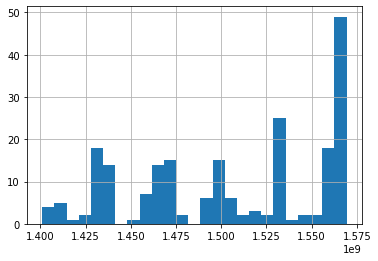

In [58]:
stories['created_utc'].hist(bins = 25)

In [59]:
p = stories['created_utc'].apply(datetime.fromtimestamp)

In [60]:
q = p.value_counts()

In [61]:
cutoff = 15

In [62]:
timesvalues = q > cutoff

In [63]:
timesvalues

2016-08-10 20:24:37    False
2018-05-08 15:37:41    False
2017-07-20 03:06:13    False
2017-05-24 05:14:38    False
2014-10-04 16:02:27    False
                       ...  
2014-09-17 04:09:19    False
2015-06-22 13:31:09    False
2019-07-20 20:11:47    False
2016-04-12 19:15:23    False
2018-09-05 03:46:42    False
Name: created_utc, Length: 214, dtype: bool

In [64]:
counts, rEdge = np.histogram(stories['created_utc'], bins = 25)

In [65]:
times = stories['created_utc']


In [66]:
if counts[0] > cutoff:
    tSeries = 1*(rEdge[0] > times).to_numpy()
else:
    tSeries = 0
    
for i in range(1, len(counts)):
    if counts[i] > cutoff:
        tSeries += ((rEdge[i-1] <= times) & (rEdge[i] > times)).to_numpy()

In [67]:
pd.DataFrame({'Times': pd.to_datetime(times, unit = 's'), 'Heatwave' : tSeries})

,Times,Heatwave
0,2014-05-25 16:42:24,0
1,2014-07-01 15:29:08,0
2,2014-07-18 05:07:04,0
3,2014-07-29 09:41:25,0
4,2014-09-17 02:09:19,0
...,...,...
9,2019-08-13 10:21:19,0
10,2019-08-13 20:02:04,0
11,2019-08-14 23:50:49,0
12,2019-09-08 20:12:48,0
